In [1]:
import cvxpy as cvx
import numpy as np

import matplotlib.pyplot as plt
from scipy import signal
import random
from sklearn.metrics import mean_absolute_error as mae

from utils import plot_decomp, plot_signal

from gfosd import Problem
from gfosd.components import *

np.random.seed(12) 
random.seed(10)

## `l1_l2d2p365`

### Create input signal

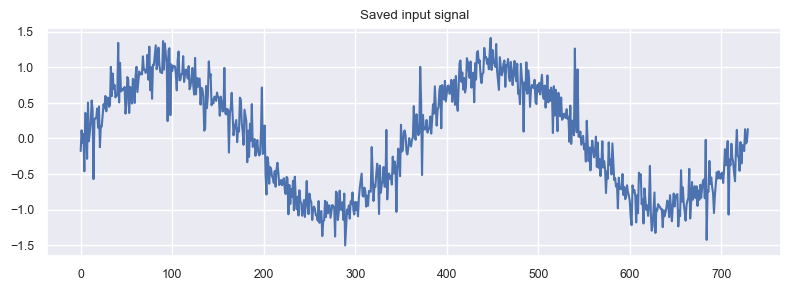

In [2]:
t = np.arange(365*2)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((2, len(t)), dtype=float)
# laplacian noise
signal2 = 0.15 * np.random.laplace(0, 1, len(signal1))

X_real[0] = signal1
X_real[1] = signal2

y = np.sum(X_real, axis=0)
plot_signal(y)

### CVXPY + MOSEK function

In [3]:
def l1_l2d2p365(
        signal,
        w1=1, 
        w2=1e3,
        yearly_periodic=True, 
        solver="MOSEK",
        verbose=False,
        s_seas_osd=None # for calculating OSD equivalent objective
):
    x = cvx.Variable(len(signal))

    objective = cvx.Minimize(
        w1 * cvx.norm1(signal - x) + w2 * cvx.norm(cvx.diff(x, k=2))
    )

    if len(signal) > 365 and yearly_periodic:
        constraints = [x[365:] == x[:-365]]  
    else:
        constraints = []

    problem = cvx.Problem(objective, constraints=constraints)

    problem.solve(solver=solver, verbose=verbose)
    
    if s_seas_osd is not None:
        print(f"CVXPY objective       {problem.objective.value:.5f}")
        x.value = s_seas_osd
        print(f"OSD objective, scaled {problem.objective.value:.5f}")
        return problem.objective.value

    return x.value, problem.objective.value

### OSD + MOSEK function

In [4]:
def gfosd_l1_l2d2p365(
        signal,
        w1=1,
        w2=1e3,
        yearly_periodic=True, 
        verbose=False
):
    '''
    - l1: laplacian noise, sum-of-absolute values or l1-norm
    - l2d2p365: small second order diffs (smooth) and 365-periodic
    '''

    c1 = SumAbs(w1)
    c2 = SumSquare(weight=w2, diff=2)
    
    if len(signal) > 365 and yearly_periodic:
        c2 = Aggregate([c2, Periodic(365)])

    classes = [c1, c2]
    
    problem = Problem(signal, classes)
    
    problem.decompose(solver='MOSEK', verbose=verbose)
    s_error =  problem.decomposition[0]
    s_seas = problem.decomposition[1]

    return s_seas, s_error, problem.objective_value

### Run with default weights (w1=1, w2=1000)

CVXPY objective       114.34820
OSD objective, scaled 141.03255
s_hat MAE (OSD,CVX)   1.98e-02


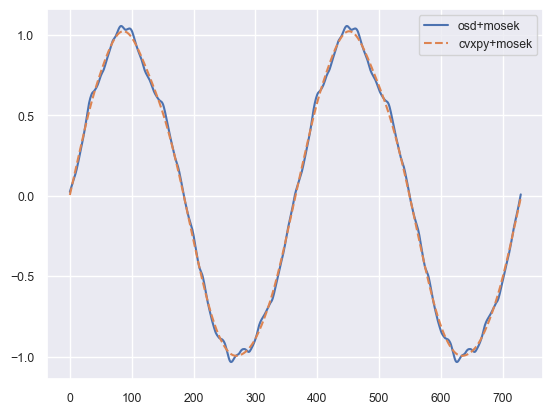

In [5]:
x_cvxpy_mosek, obj_cvxpy_mosek = l1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_l1_l2d2p365(y)

obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();

### Run w/ CVXPY with default weights, OSD with hand-tuned weights (w1=0.001, w2=220)

CVXPY objective       114.34820
OSD objective, scaled 114.37009
s_hat MAE (OSD,CVX)   2.52e-03


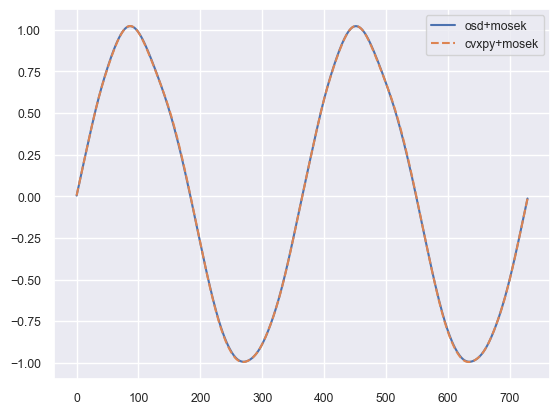

In [6]:
x_cvxpy_mosek, obj_cvxpy_mosek = l1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_l1_l2d2p365(y, w1=0.001, w2=220)

obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();

### Run w/ CVXPY with default weights, OSD with other hand-tuned weights (w1=0.007, w2=1000)

CVXPY objective       114.34820
OSD objective, scaled 114.35069
s_hat MAE (OSD,CVX)   4.82e-04


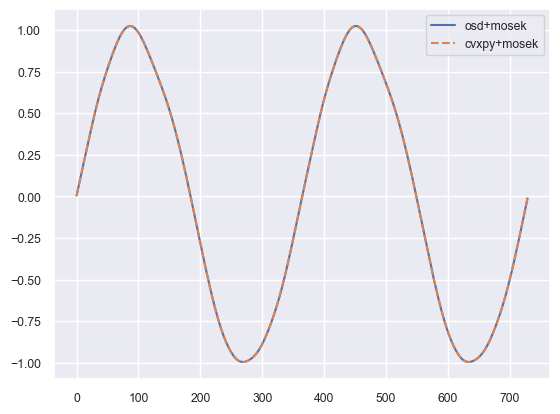

In [7]:
x_cvxpy_mosek, obj_cvxpy_mosek = l1_l2d2p365(y)
x_osd_mosek, err_osd_mosek, obj_osd_mosek = gfosd_l1_l2d2p365(y, w1=0.007, w2=1000)

obj_osd_scaled = l1_l2d2p365(y, s_seas_osd=x_osd_mosek) 
print(f's_hat MAE (OSD,CVX)   {mae(x_osd_mosek, x_cvxpy_mosek):.2e}')

plt.plot(x_osd_mosek, label="osd+mosek")
plt.plot(x_cvxpy_mosek, linestyle="--", label="cvxpy+mosek")
plt.legend();